Predicting WIG20 market volatility regimes

In this notebook I have tried to develop and evaluate machine learning models that classify volatility periods (either high or low volatility) in WIG20 data. I have divided my work between data loading, cleaning, EDA, feature engineering, model training, model comparision and interpretation of results. My goal was to identify which model performs best for the given task.

1. Importing libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import joblib

2. Loading and cleaning data

In [3]:
df = pd.read_csv("data/wig20_d.csv")

# Renaming Polish columns to English 
df = df.rename(columns={
    'Data': 'Date',
    'Otwarcie': 'Open',
    'Najwyzszy': 'High',
    'Najnizszy': 'Low',
    'Zamkniecie': 'Close',
    'Wolumen': 'Volume'
}, errors='ignore')  # ignore any missing ones

# Converting Date column
df['Date'] = pd.to_datetime(df['Date'])

# Sorting chronologically
df = df.sort_values('Date').reset_index(drop=True)

df.head()

,Date,Open,High,Low,Close,Volume
0,1991-04-16,100.0,100.0,100.0,100.0,325.0
1,1991-04-23,95.7,95.7,95.7,95.7,5905.0
2,1991-04-30,93.5,93.5,93.5,93.5,7162.0
3,1991-05-14,92.9,92.9,92.9,92.9,18300.0
4,1991-05-21,95.5,95.5,95.5,95.5,14750.0


In [4]:
# Simple returns
df['return'] = df['Close'].pct_change()

# Log returns
df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))

df.head(10)

,Date,Open,High,Low,Close,Volume,return,log_return
0,1991-04-16,100.0,100.0,100.0,100.0,325.0,NaN,NaN
1,1991-04-23,95.7,95.7,95.7,95.7,5905.0,-0.043000,-0.043952
2,1991-04-30,93.5,93.5,93.5,93.5,7162.0,-0.022989,-0.023257
3,1991-05-14,92.9,92.9,92.9,92.9,18300.0,-0.006417,-0.006438
4,1991-05-21,95.5,95.5,95.5,95.5,14750.0,0.027987,0.027603
5,1991-05-28,94.6,94.6,94.6,94.6,31440.0,-0.009424,-0.009469
6,1991-06-04,95.8,95.8,95.8,95.8,12396.0,0.012685,0.012605
7,1991-06-11,95.0,95.0,95.0,95.0,26247.0,-0.008351,-0.008386
8,1991-06-18,85.7,85.7,85.7,85.7,33496.0,-0.097895,-0.103024
9,1991-06-25,84.1,84.1,84.1,84.1,25264.0,-0.018670,-0.018846


In [5]:
# Rolling volatility: standard deviation of log returns over a 10-day window
# A high volatility regime is defined when the current volatility exceeds the 50-day rolling mean plus one rolling standard deviation:

# High volatility regime (labeled as '1') = Current 10-day volatility > (historical 50-day mean + historical 50-day std).

# My threshold approach follows a common methodology in quantitative finance, where short term volatility is compared against long term benchmark.
# Simillar techniques are discussed in: López de Prado, "Advances in Financial Machine Learning", Wiley, 2018.
df['volatility'] = df['log_return'].rolling(window=10).std()
df['vol_mean'] = df['volatility'].rolling(window=50).mean()
df['vol_std'] = df['volatility'].rolling(window=50).std()
df['regime'] = (df['volatility'] > df['vol_mean'] + df['vol_std']).astype(int)
df[['Date', 'volatility', 'vol_mean', 'vol_std', 'regime']].head(20)
df[df['regime'] == 1].head()

,Date,Open,High,Low,Close,Volume,return,log_return,volatility,vol_mean,vol_std,regime
85,1992-07-02,78.3,78.3,78.3,78.3,36365.0,0.095105,0.090850,0.051321,0.027046,0.015112,1
86,1992-07-07,85.2,85.2,85.2,85.2,1492181.0,0.088123,0.084454,0.056933,0.026762,0.014382,1
87,1992-07-09,86.1,86.1,86.1,86.1,1164413.0,0.010563,0.010508,0.056653,0.026569,0.013897,1
88,1992-07-14,83.0,83.0,83.0,83.0,984868.0,-0.036005,-0.036669,0.057135,0.026451,0.013604,1
89,1992-07-16,84.4,84.4,84.4,84.4,904914.0,0.016867,0.016727,0.055713,0.026307,0.013241,1


3. Exploratory data analysis

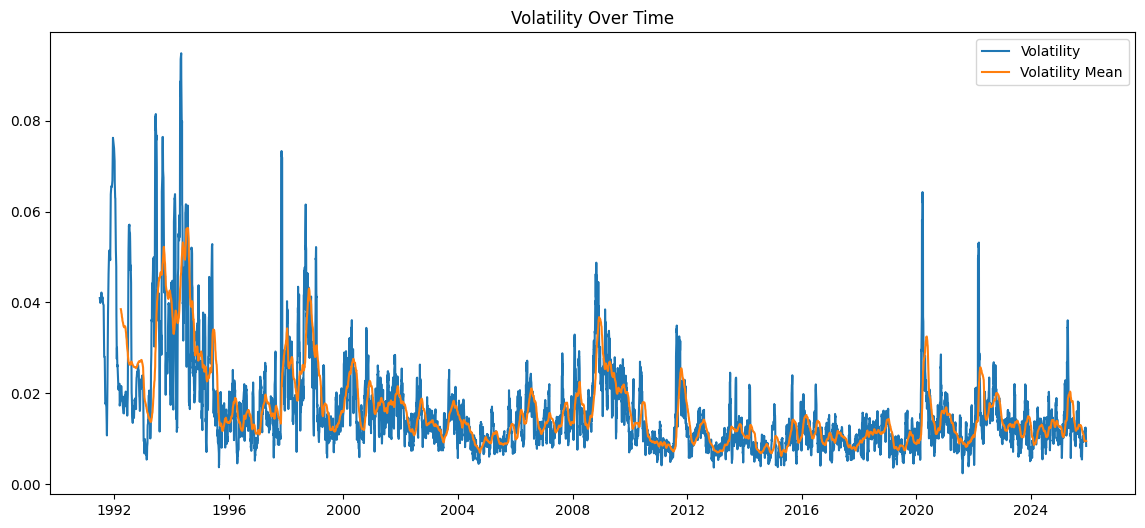

In [6]:

plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['volatility'], label='Volatility')
plt.plot(df['Date'], df['vol_mean'], label='Volatility Mean')
plt.title('Volatility Over Time')
plt.legend()
plt.show()

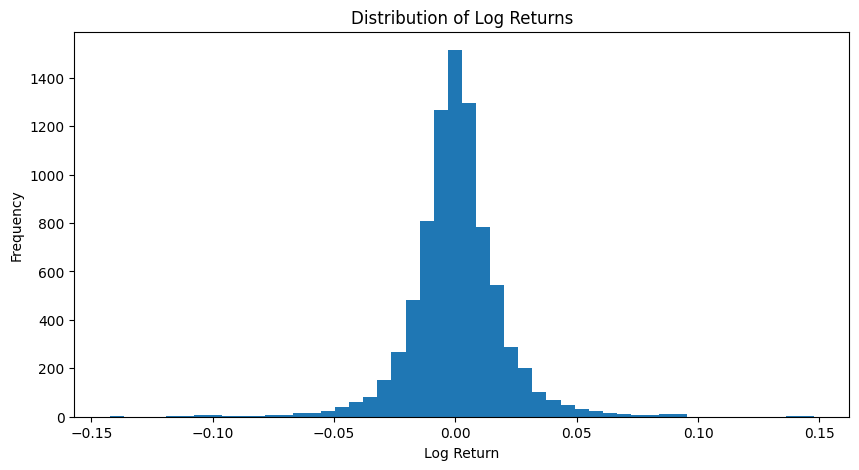

In [7]:
plt.figure(figsize=(10,5))
plt.hist(df['log_return'].dropna(), bins=50)
plt.title("Distribution of Log Returns")
plt.xlabel("Log Return")
plt.ylabel("Frequency")
plt.show()

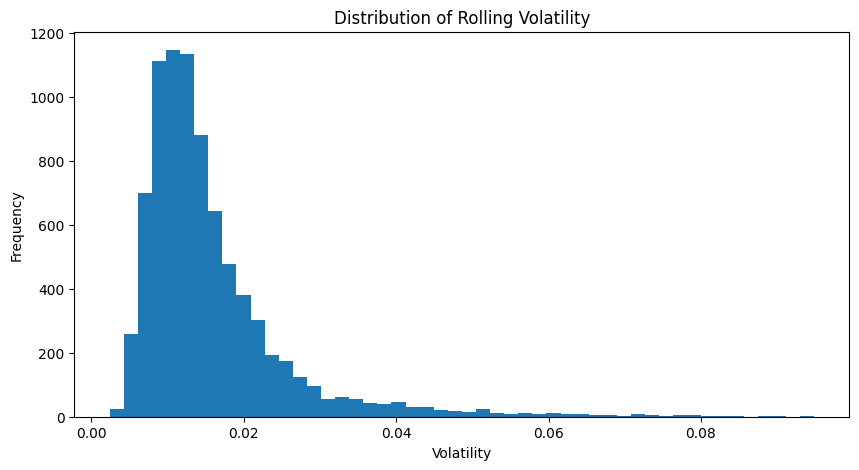

In [8]:
plt.figure(figsize=(10,5))
plt.hist(df['volatility'].dropna(), bins=50)
plt.title("Distribution of Rolling Volatility")
plt.xlabel("Volatility")
plt.ylabel("Frequency")
plt.show()

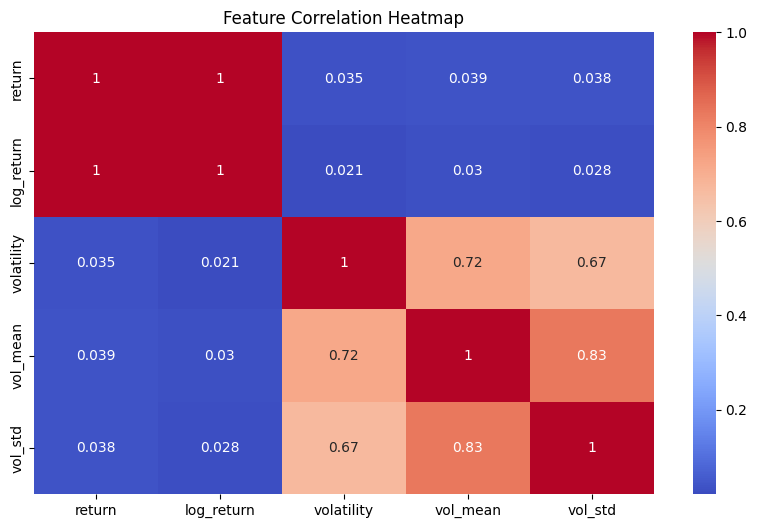

In [9]:

plt.figure(figsize=(10,6))
sns.heatmap(df[['return','log_return','volatility','vol_mean','vol_std']].corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

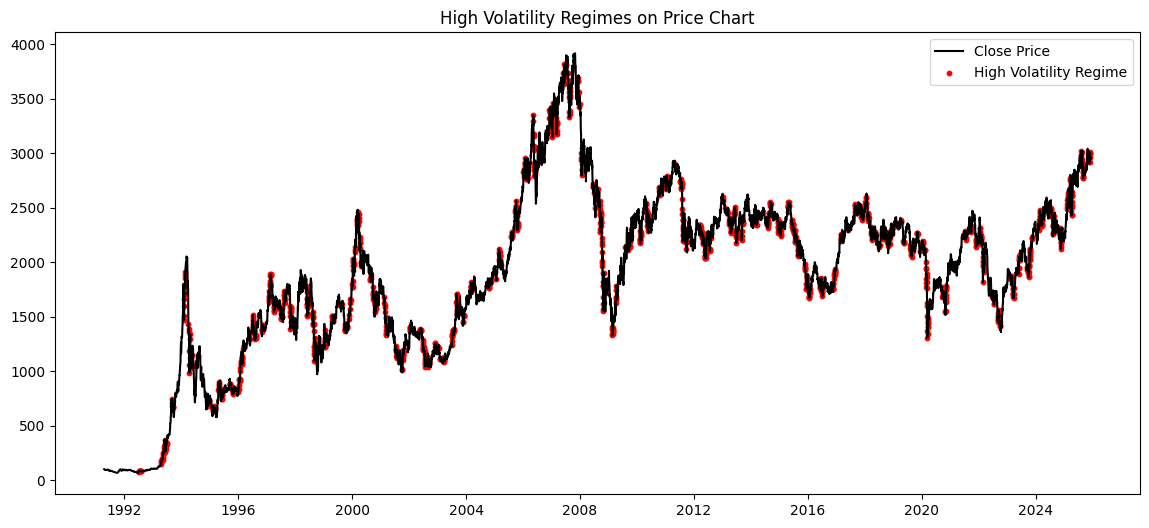

In [10]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close Price', color='black')

# high volatility regimes
plt.scatter(df['Date'][df['regime'] == 1], 
            df['Close'][df['regime'] == 1],
            color='red', s=10, label='High Volatility Regime')

plt.title("High Volatility Regimes on Price Chart")
plt.legend()
plt.show()

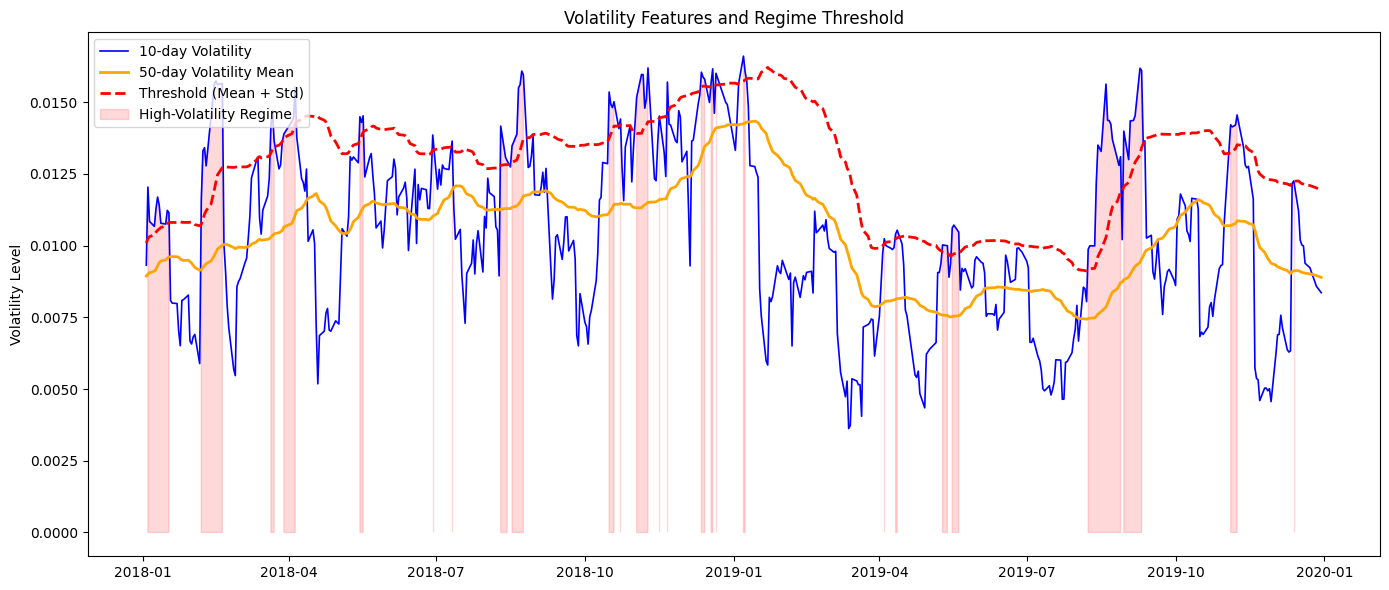

In [14]:
sample = df[(df['Date'] > '2018-01-01') & (df['Date'] < '2020-01-01')]

plt.figure(figsize=(14,6))

# Plot volatility 
plt.plot(sample['Date'], sample['volatility'], 
         label='10-day Volatility', color='blue', linewidth=1.2)

# Plot long-term mean
plt.plot(sample['Date'], sample['vol_mean'], 
         label='50-day Volatility Mean', color='orange', linewidth=2)

# Plot threshold
plt.plot(sample['Date'], sample['vol_mean'] + sample['vol_std'], 
         label='Threshold (Mean + Std)', color='red', linestyle='--', linewidth=2)

# Highlight high-vol regimes with shading
high_vol_periods = sample[sample['regime'] == 1]

plt.fill_between(
    sample['Date'], 
    0, 
    sample['volatility'],
    where=sample['regime'] == 1,
    color='red',
    alpha=0.15,
    label='High-Volatility Regime'
)

plt.title("Volatility Features and Regime Threshold")
plt.ylabel("Volatility Level")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()

4. Feature engineering

In [71]:
# Rolling mean of closing prices
df['roll_mean_5'] = df['Close'].rolling(window=5).mean()
df['roll_mean_10'] = df['Close'].rolling(window=10).mean()

# Rolling standard deviation
df['roll_std_5'] = df['Close'].rolling(window=5).std()
df['roll_std_10'] = df['Close'].rolling(window=10).std()

# Rolling max and min
df['roll_max_5'] = df['Close'].rolling(window=5).max()
df['roll_min_5'] = df['Close'].rolling(window=5).min()

# Rolling return
df['roll_return_5'] = df['Close'].pct_change(periods=5)
df['roll_return_10'] = df['Close'].pct_change(periods=10)

# Skewness and Kurtosis
df['roll_skew_10'] = df['log_return'].rolling(window=10).skew()
df['roll_kurt_10'] = df['log_return'].rolling(window=10).kurt()

df[['Date', 'Close', 'roll_mean_5', 'roll_std_5', 'roll_max_5', 'roll_return_5']].head(15)

,Date,Close,roll_mean_5,roll_std_5,roll_max_5,roll_return_5
0,1991-04-16,100.0,NaN,NaN,NaN,NaN
1,1991-04-23,95.7,NaN,NaN,NaN,NaN
2,1991-04-30,93.5,NaN,NaN,NaN,NaN
3,1991-05-14,92.9,NaN,NaN,NaN,NaN
4,1991-05-21,95.5,95.52,2.786037,100.0,NaN
5,1991-05-28,94.6,94.44,1.223928,95.7,-0.054000
6,1991-06-04,95.8,94.46,1.250200,95.8,0.001045
7,1991-06-11,95.0,94.76,1.137102,95.8,0.016043
8,1991-06-18,85.7,93.32,4.284507,95.8,-0.077503
9,1991-06-25,84.1,91.04,5.650044,95.8,-0.119372


In [72]:
# Lagged returns
df['lag_return_1'] = df['log_return'].shift(1)
df['lag_return_3'] = df['log_return'].shift(3)
df['lag_return_5'] = df['log_return'].shift(5)

# Lagged volatility
df['lag_vol_1'] = df['volatility'].shift(1)
df['lag_vol_3'] = df['volatility'].shift(3)
df['lag_vol_5'] = df['volatility'].shift(5)

# lagged close price
df['lag_close_1'] = df['Close'].shift(1)
df['lag_close_3'] = df['Close'].shift(3)
df['lag_close_5'] = df['Close'].shift(5)

df[['Date', 'Close', 'lag_close_1', 'lag_return_1', 'lag_vol_1']].head(12)

,Date,Close,lag_close_1,lag_return_1,lag_vol_1
0,1991-04-16,100.0,NaN,NaN,NaN
1,1991-04-23,95.7,100.0,NaN,NaN
2,1991-04-30,93.5,95.7,-0.043952,NaN
3,1991-05-14,92.9,93.5,-0.023257,NaN
4,1991-05-21,95.5,92.9,-0.006438,NaN
5,1991-05-28,94.6,95.5,0.027603,NaN
6,1991-06-04,95.8,94.6,-0.009469,NaN
7,1991-06-11,95.0,95.8,0.012605,NaN
8,1991-06-18,85.7,95.0,-0.008386,NaN
9,1991-06-25,84.1,85.7,-0.103024,NaN


In [73]:
# RSI calculation
window = 14

# Price change from the preavious day
delta = df['Close'].diff()

# Separate gains and losses
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)

# Average gain/loss
avg_gain = gain.rolling(window=window, min_periods=window).mean()
avg_loss = loss.rolling(window=window, min_periods=window).mean()

# Wilder's smoothing
avg_gain = avg_gain.ewm(alpha=1/window, adjust=False).mean()
avg_loss = avg_loss.ewm(alpha=1/window, adjust=False).mean()

# Relative strength
rs = avg_gain / avg_loss

# RSI formula
df['rsi_14'] = 100 - (100 / (1 + rs))

df[['Date', 'Close', 'rsi_14']].head(20)

,Date,Close,rsi_14
0,1991-04-16,100.0,NaN
1,1991-04-23,95.7,NaN
2,1991-04-30,93.5,NaN
3,1991-05-14,92.9,NaN
4,1991-05-21,95.5,NaN
5,1991-05-28,94.6,NaN
6,1991-06-04,95.8,NaN
7,1991-06-11,95.0,NaN
8,1991-06-18,85.7,NaN
9,1991-06-25,84.1,NaN


In [74]:
# MACD
# Parameters
short_window = 12
long_window = 26
signal_window = 9

# Exponential moving average (EMA)
ema_short = df['Close'].ewm(span=short_window, adjust=False).mean()
ema_long = df['Close'].ewm(span=long_window, adjust=False).mean()

# MACD line
df['macd'] = ema_short - ema_long

# Signal line (EMA of MACD)
df['macd_signal'] = df['macd'].ewm(span=signal_window, adjust=False).mean()

# Strength of momentum
df['macd_hist'] = df['macd'] - df['macd_signal']

df[['Date', 'Close', 'macd', 'macd_signal', 'macd_hist']].head(20)


,Date,Close,macd,macd_signal,macd_hist
0,1991-04-16,100.0,0.000000,0.000000,0.000000
1,1991-04-23,95.7,-0.343020,-0.068604,-0.274416
2,1991-04-30,93.5,-0.783357,-0.211555,-0.571803
3,1991-05-14,92.9,-1.167287,-0.402701,-0.764586
4,1991-05-21,95.5,-1.247377,-0.571636,-0.675741
5,1991-05-28,94.6,-1.367705,-0.730850,-0.636855
6,1991-06-04,95.8,-1.350666,-0.854813,-0.495853
7,1991-06-11,95.0,-1.385742,-0.960999,-0.424743
8,1991-06-18,85.7,-2.139312,-1.196662,-0.942650
9,1991-06-25,84.1,-2.832971,-1.523924,-1.309048


In [75]:
# Bollinger bands
window = 20

# Middle band
df['bb_mid'] = df['Close'].rolling(window=window).mean()

# Rolling standard deviation
bb_std = df['Close'].rolling(window=window).std()

# Upper and lower bands
df['bb_upper'] = df['bb_mid'] + 2 * bb_std
df['bb_lower'] = df['bb_mid'] - 2 * bb_std

# Band width
df['bb_width'] = df['bb_upper'] - df['bb_lower']

df[['Date','Close','bb_mid','bb_upper','bb_lower','bb_width']].head(25)

,Date,Close,bb_mid,bb_upper,bb_lower,bb_width
0,1991-04-16,100.0,NaN,NaN,NaN,NaN
1,1991-04-23,95.7,NaN,NaN,NaN,NaN
2,1991-04-30,93.5,NaN,NaN,NaN,NaN
3,1991-05-14,92.9,NaN,NaN,NaN,NaN
4,1991-05-21,95.5,NaN,NaN,NaN,NaN
5,1991-05-28,94.6,NaN,NaN,NaN,NaN
6,1991-06-04,95.8,NaN,NaN,NaN,NaN
7,1991-06-11,95.0,NaN,NaN,NaN,NaN
8,1991-06-18,85.7,NaN,NaN,NaN,NaN
9,1991-06-25,84.1,NaN,NaN,NaN,NaN


In [76]:
# Stochastic oscilator
k_window = 14
d_window = 3

# Rolling highest high and lowest low
low_14 = df['Low'].rolling(window=k_window).min()
high_14 = df['High'].rolling(window=k_window).max()

# %K calculation
df['stoch_k'] = 100 * (df['Close'] - low_14) / (high_14 - low_14)

# %D = 3-day moving average of %K
df['stoch_d'] = df['stoch_k'].rolling(window=d_window).mean()

df[['Date', 'Close', 'stoch_k', 'stoch_d']].head(20)

,Date,Close,stoch_k,stoch_d
0,1991-04-16,100.0,NaN,NaN
1,1991-04-23,95.7,NaN,NaN
2,1991-04-30,93.5,NaN,NaN
3,1991-05-14,92.9,NaN,NaN
4,1991-05-21,95.5,NaN,NaN
5,1991-05-28,94.6,NaN,NaN
6,1991-06-04,95.8,NaN,NaN
7,1991-06-11,95.0,NaN,NaN
8,1991-06-18,85.7,NaN,NaN
9,1991-06-25,84.1,NaN,NaN


In [77]:
# True range
df['prev_close'] = df['Close'].shift(1)

df['tr1'] = df['High'] - df['Low']
df['tr2'] = (df['High'] - df['prev_close']).abs()
df['tr3'] = (df['Low'] - df['prev_close']).abs()

df['true_range'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

df[['Date', 'High', 'Low', 'prev_close', 'true_range']].head(15)



,Date,High,Low,prev_close,true_range
0,1991-04-16,100.0,100.0,NaN,0.0
1,1991-04-23,95.7,95.7,100.0,4.3
2,1991-04-30,93.5,93.5,95.7,2.2
3,1991-05-14,92.9,92.9,93.5,0.6
4,1991-05-21,95.5,95.5,92.9,2.6
5,1991-05-28,94.6,94.6,95.5,0.9
6,1991-06-04,95.8,95.8,94.6,1.2
7,1991-06-11,95.0,95.0,95.8,0.8
8,1991-06-18,85.7,85.7,95.0,9.3
9,1991-06-25,84.1,84.1,85.7,1.6


In [78]:
# Average true range
df['atr_14'] = df['true_range'].rolling(window=14).mean()

df[['Date', 'true_range', 'atr_14']].head(20)

,Date,true_range,atr_14
0,1991-04-16,0.0,NaN
1,1991-04-23,4.3,NaN
2,1991-04-30,2.2,NaN
3,1991-05-14,0.6,NaN
4,1991-05-21,2.6,NaN
5,1991-05-28,0.9,NaN
6,1991-06-04,1.2,NaN
7,1991-06-11,0.8,NaN
8,1991-06-18,9.3,NaN
9,1991-06-25,1.6,NaN


In [79]:
# Bollinger spread
df['bb_spread'] = (df['bb_upper'] - df['bb_lower']) / df['bb_mid']
df[['Date', 'bb_width', 'bb_spread']].head(20)

,Date,bb_width,bb_spread
0,1991-04-16,NaN,NaN
1,1991-04-23,NaN,NaN
2,1991-04-30,NaN,NaN
3,1991-05-14,NaN,NaN
4,1991-05-21,NaN,NaN
5,1991-05-28,NaN,NaN
6,1991-06-04,NaN,NaN
7,1991-06-11,NaN,NaN
8,1991-06-18,NaN,NaN
9,1991-06-25,NaN,NaN


In [80]:
df[['true_range', 'atr_14', 'bb_width', 'bb_spread']].describe()

,true_range,atr_14,bb_width,bb_spread
count,8216.000000,8203.000000,8197.000000,8197.000000
mean,37.171710,37.197510,207.224885,0.121631
std,25.393373,18.665438,133.980850,0.106644
min,0.000000,0.471429,4.946876,0.018547
25%,21.607500,26.213214,122.052690,0.063556
50%,31.640000,33.718571,177.358113,0.090852
75%,46.580000,44.225000,252.384098,0.139294
max,292.540000,138.932857,1544.448113,1.215706


In [81]:
df[['true_range', 'atr_14', 'bb_width', 'bb_spread']].isna().sum()

true_range     0
atr_14        13
bb_width      19
bb_spread     19
dtype: int64

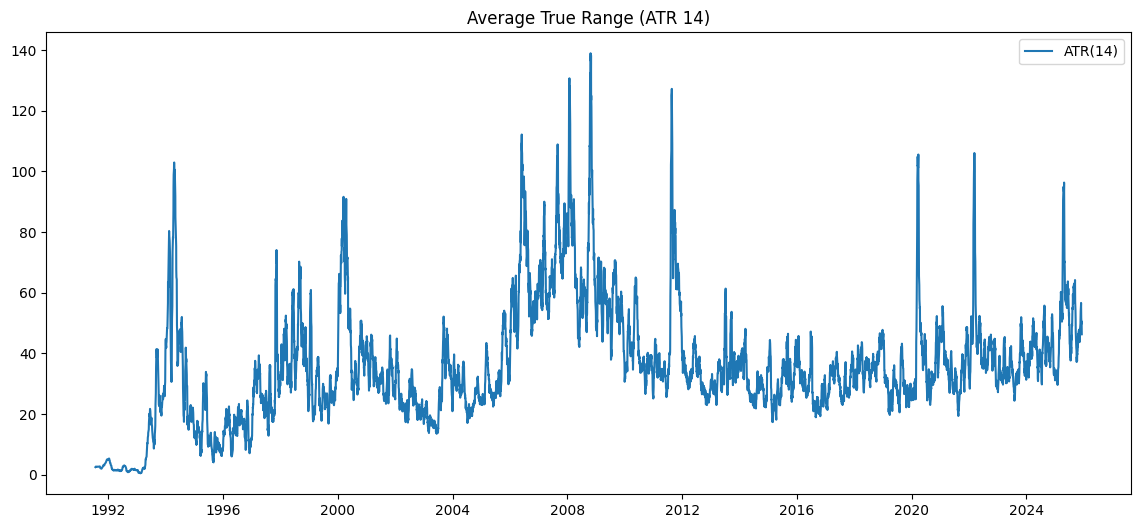

In [82]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['atr_14'], label='ATR(14)')
plt.title("Average True Range (ATR 14)")
plt.legend()
plt.show()

In [83]:
# Volume % change
df['vol_pct_change'] = df['Volume'].pct_change()

# Volume Z score (unusual activity)
# Rolling mean and std of volume
df['vol_roll_mean_20'] = df['Volume'].rolling(window=20).mean()
df['vol_roll_std_20'] = df['Volume'].rolling(window=20).std()

#Z score
df['vol_zscore_20'] = (df['Volume'] - df['vol_roll_mean_20'] / df['vol_roll_std_20'])

# Rolling average volume
df['vol_roll_avg_20'] = df['Volume'].rolling(window=20).mean()
df['vol_roll_avg_50'] = df['Volume'].rolling(window=50).mean()

df[['Date', 'Volume', 'vol_pct_change', 'vol_zscore_20', 'vol_roll_avg_20']].head(25)


,Date,Volume,vol_pct_change,vol_zscore_20,vol_roll_avg_20
0,1991-04-16,325.0,NaN,NaN,NaN
1,1991-04-23,5905.0,17.169231,NaN,NaN
2,1991-04-30,7162.0,0.212870,NaN,NaN
3,1991-05-14,18300.0,1.555152,NaN,NaN
4,1991-05-21,14750.0,-0.193989,NaN,NaN
5,1991-05-28,31440.0,1.131525,NaN,NaN
6,1991-06-04,12396.0,-0.605725,NaN,NaN
7,1991-06-11,26247.0,1.117377,NaN,NaN
8,1991-06-18,33496.0,0.276184,NaN,NaN
9,1991-06-25,25264.0,-0.245761,NaN,NaN


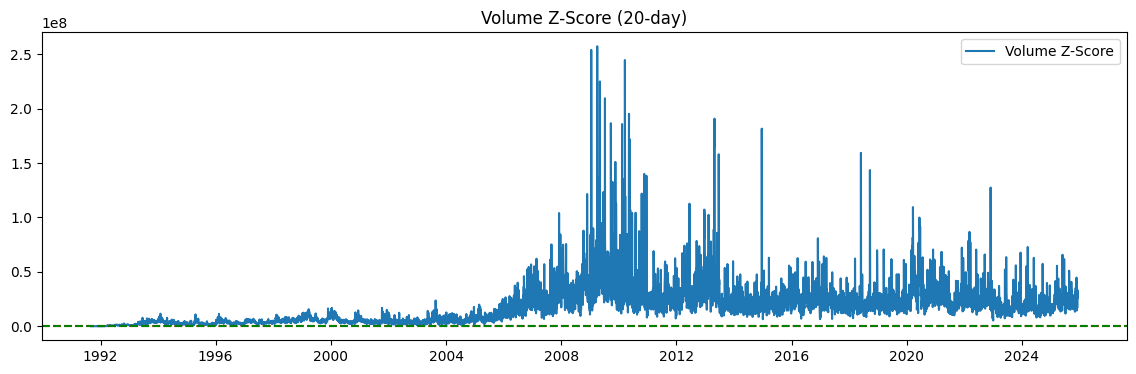

In [84]:
plt.figure(figsize=(14,4))
plt.plot(df['Date'], df['vol_zscore_20'], label='Volume Z-Score')
plt.axhline(2, color='red', linestyle='--')
plt.axhline(-2, color='green', linestyle='--')
plt.title("Volume Z-Score (20-day)")
plt.legend()
plt.show()

In [85]:
# Dropping rows with NaN values
df_clean = df.dropna().reset_index(drop=True)
df_clean.shape

(8157, 54)

In [86]:
# Checking class distribution of the target
df_clean['regime'].value_counts()

regime
0    6497
1    1660
Name: count, dtype: int64

In [87]:
# Checking data types
df_clean.dtypes

Date                datetime64[ns]
Open                       float64
High                       float64
Low                        float64
Close                      float64
Volume                     float64
return                     float64
log_return                 float64
volatility                 float64
vol_mean                   float64
vol_std                    float64
regime                       int64
roll_mean_5                float64
roll_mean_10               float64
roll_std_5                 float64
roll_std_10                float64
roll_max_5                 float64
roll_min_5                 float64
roll_return_5              float64
roll_return_10             float64
roll_skew_10               float64
roll_kurt_10               float64
lag_return_1               float64
lag_return_3               float64
lag_return_5               float64
lag_vol_1                  float64
lag_vol_3                  float64
lag_vol_5                  float64
lag_close_1         

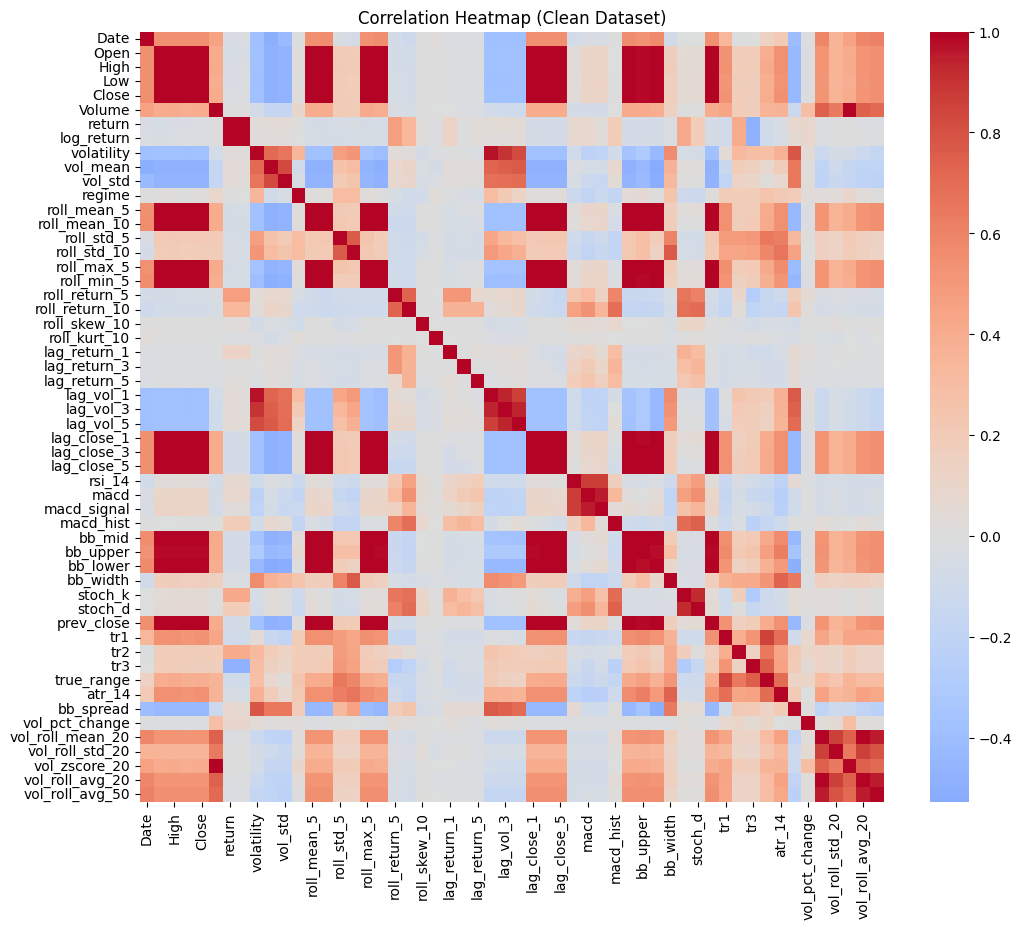

In [88]:
# Detecting correlations
plt.figure(figsize=(12,10))
sns.heatmap(df_clean.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap (Clean Dataset)")
plt.show()

In [89]:
# Identifing multicorrlinearity
corr = df_clean.corr().abs()
high_corr = corr[corr > 0.90]
high_corr

,Date,Open,High,Low,Close,Volume,return,log_return,volatility,vol_mean,...,tr3,true_range,atr_14,bb_spread,vol_pct_change,vol_roll_mean_20,vol_roll_std_20,vol_zscore_20,vol_roll_avg_20,vol_roll_avg_50
Date,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Open,NaN,1.000000,0.999712,0.999636,0.999287,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
High,NaN,0.999712,1.000000,0.999582,0.999682,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Low,NaN,0.999636,0.999582,1.000000,0.999698,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Close,NaN,0.999287,0.999682,0.999698,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Volume,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN
return,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,0.999647,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
log_return,NaN,NaN,NaN,NaN,NaN,NaN,0.999647,1.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
volatility,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
vol_mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [90]:
# Feature summary
df_clean.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,8157,2009-08-12 13:47:46.495034880,1992-03-26 00:00:00,2001-07-03 00:00:00,2009-08-18 00:00:00,2017-10-09 00:00:00,2025-12-05 00:00:00,NaN
Open,8157.0,1979.543511,62.8,1561.9,2038.67,2390.39,3935.47,671.401928
High,8157.0,1994.441529,62.8,1574.7,2054.96,2407.09,3940.53,676.691988
Low,8157.0,1963.149964,62.8,1547.1,2019.23,2372.62,3910.96,664.574826
Close,8157.0,1979.085888,62.8,1561.9,2036.32,2389.04,3917.87,670.812351
Volume,8157.0,18434821.544157,36365.0,5182734.0,16177462.0,25052568.0,257333286.0,17847709.163371
return,8157.0,0.000598,-0.132774,-0.008523,0.00021,0.009018,0.159341,0.018615
log_return,8157.0,0.000425,-0.142456,-0.00856,0.00021,0.008978,0.147852,0.018614
volatility,8157.0,0.015526,0.002394,0.009713,0.01305,0.018045,0.094871,0.00964
vol_mean,8157.0,0.015605,0.006212,0.010629,0.013296,0.017841,0.056433,0.007753


In [91]:
# Removing highly correlated features
# Finding pairs of highly correlated features
corr_matrix = df_clean.corr().abs()

# Saving pairs with correlation > 0.90
high_corr_pairs = [
    (col1, col2)
    for col1 in corr_matrix.columns
    for col2 in corr_matrix.columns
    if col1 != col2 and corr_matrix.loc[col1, col2] > 0.90
]

high_corr_pairs[:20]  

[('Open', 'High'),
 ('Open', 'Low'),
 ('Open', 'Close'),
 ('Open', 'roll_mean_5'),
 ('Open', 'roll_mean_10'),
 ('Open', 'roll_max_5'),
 ('Open', 'roll_min_5'),
 ('Open', 'lag_close_1'),
 ('Open', 'lag_close_3'),
 ('Open', 'lag_close_5'),
 ('Open', 'bb_mid'),
 ('Open', 'bb_upper'),
 ('Open', 'bb_lower'),
 ('Open', 'prev_close'),
 ('High', 'Open'),
 ('High', 'Low'),
 ('High', 'Close'),
 ('High', 'roll_mean_5'),
 ('High', 'roll_mean_10'),
 ('High', 'roll_max_5')]

In [92]:
features_to_drop = [
    'roll_mean_5',
    'roll_mean_10',
    'roll_max_5',
    'roll_min_5',
    'lag_close_3',
    'lag_close_5',
    'prev_close',
    'bb_mid',
    'bb_upper',
    'bb_lower'
]

df_clean = df_clean.drop(columns=features_to_drop, errors='ignore')

In [93]:
df_clean = df_clean.drop(columns=['Date'], errors='ignore')

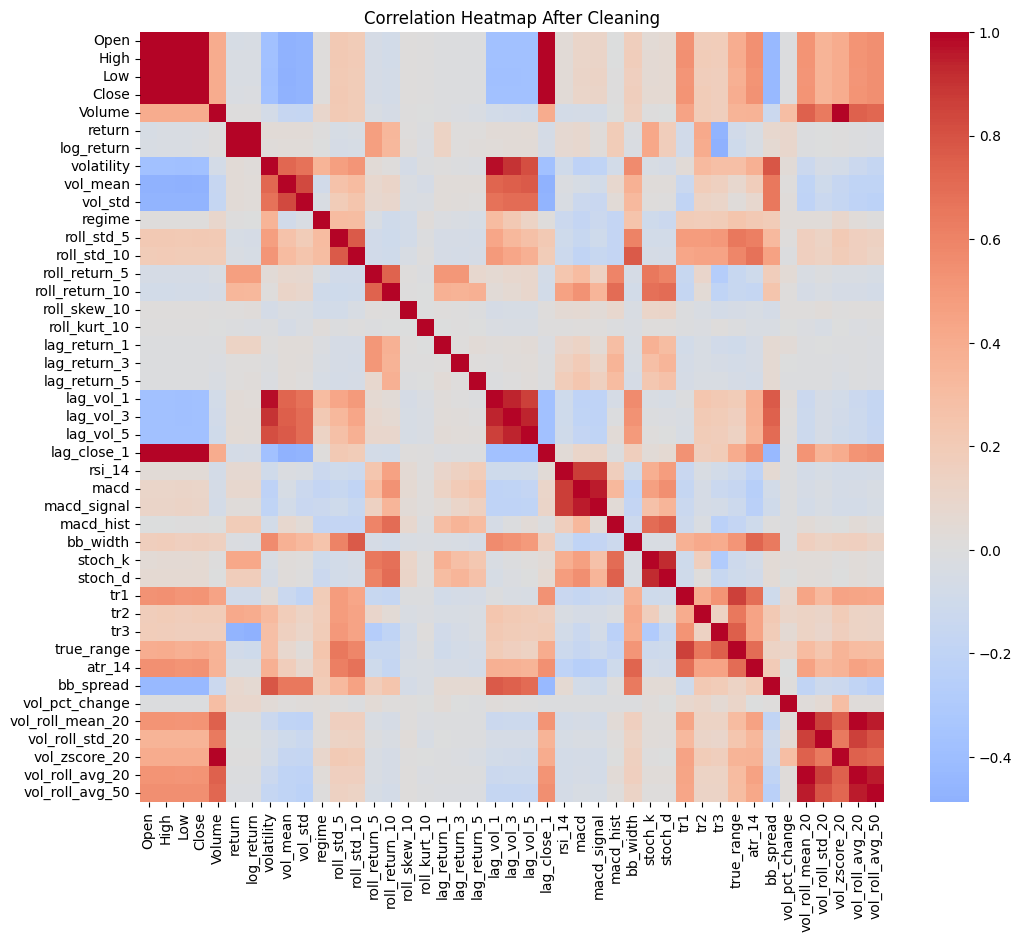

In [94]:
plt.figure(figsize=(12,10))
sns.heatmap(df_clean.corr(), cmap="coolwarm", center=0)
plt.title("Correlation Heatmap After Cleaning")
plt.show()

5. Model training

In [95]:
# y = target variable
y = df_clean['regime']

# x = feature matrix
X = df_clean.drop(columns=['regime'])

X.head()
y.head()

0    0
1    0
2    0
3    0
4    0
Name: regime, dtype: int64

In [96]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)
# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train.shape, X_test.shape

((6525, 42), (1632, 42))

In [97]:
# Logistic Regression


log_reg = LogisticRegression(max_iter=500)


log_reg.fit(X_train_scaled, y_train)


y_pred_lr = log_reg.predict(X_test_scaled)

print("LOGISTIC REGRESSION REPORT:\n")
print(classification_report(y_test, y_pred_lr))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_lr))

LOGISTIC REGRESSION REPORT:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.98      0.93      0.95       332

    accuracy                           0.98      1632
   macro avg       0.98      0.96      0.97      1632
weighted avg       0.98      0.98      0.98      1632


CONFUSION MATRIX:
[[1293    7]
 [  23  309]]


In [98]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=10,
    random_state=42,
    class_weight='balanced'  
)

rf.fit(X_train, y_train) 

y_pred_rf = rf.predict(X_test)

print("RANDOM FOREST REPORT:\n")
print(classification_report(y_test, y_pred_rf))

print("\nCONFUSION MATRIX:")
print(confusion_matrix(y_test, y_pred_rf))

RANDOM FOREST REPORT:

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1300
           1       0.88      0.80      0.84       332

    accuracy                           0.94      1632
   macro avg       0.92      0.89      0.90      1632
weighted avg       0.94      0.94      0.94      1632


CONFUSION MATRIX:
[[1265   35]
 [  67  265]]


In [100]:
# Gradient Boosting

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

print(classification_report(y_test, y_pred_gb))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.97      0.90      0.93       332

    accuracy                           0.97      1632
   macro avg       0.97      0.94      0.96      1632
weighted avg       0.97      0.97      0.97      1632



6. Model comparision

In [101]:
models = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb

}

for name, preds in models.items():
    print(f"--- {name} ---")
    print(classification_report(y_test, preds))
    print()

--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      1300
           1       0.98      0.93      0.95       332

    accuracy                           0.98      1632
   macro avg       0.98      0.96      0.97      1632
weighted avg       0.98      0.98      0.98      1632


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1300
           1       0.88      0.80      0.84       332

    accuracy                           0.94      1632
   macro avg       0.92      0.89      0.90      1632
weighted avg       0.94      0.94      0.94      1632


--- Gradient Boosting ---
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      1300
           1       0.97      0.90      0.93       332

    accuracy                           0.97      1632
   macro avg       0.97      0.94      0.96      1

7. Results

In [102]:
results = []

models_dict = {
    "Logistic Regression": y_pred_lr,
    "Random Forest": y_pred_rf,
    "Gradient Boosting": y_pred_gb
}

for name, preds in models_dict.items():
    results.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, preds),
        "Precision": precision_score(y_test, preds),
        "Recall": recall_score(y_test, preds),
        "F1 Score": f1_score(y_test, preds)
    })

results_df = pd.DataFrame(results)
results_df

,Model,Accuracy,Precision,Recall,F1 Score
0,Logistic Regression,0.981618,0.977848,0.930723,0.953704
1,Random Forest,0.937500,0.883333,0.798193,0.838608
2,Gradient Boosting,0.973039,0.967532,0.897590,0.931250


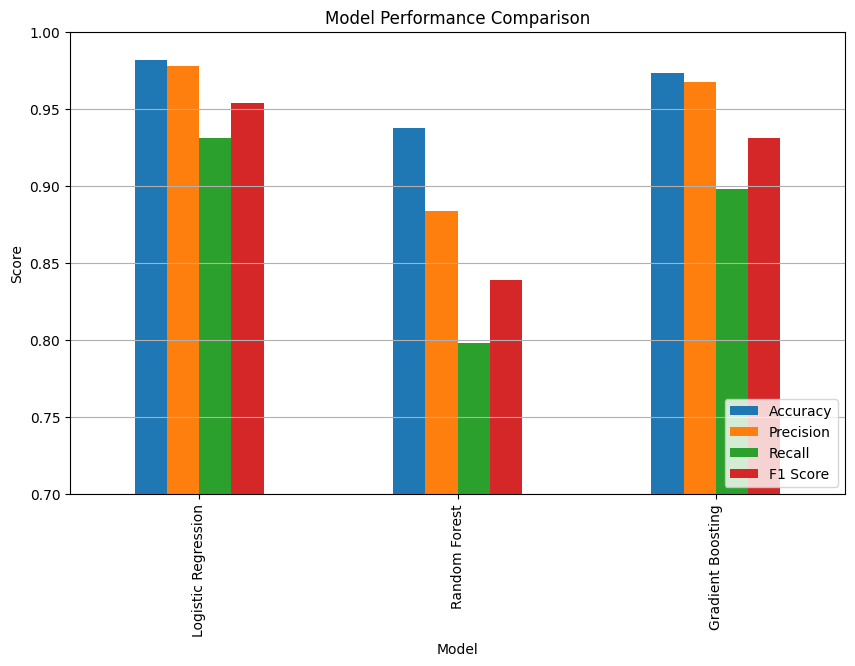

In [103]:
results_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(
    kind="bar", figsize=(10,6)
)
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.ylim(0.7, 1)
plt.legend(loc="lower right")
plt.grid(axis='y')
plt.show()

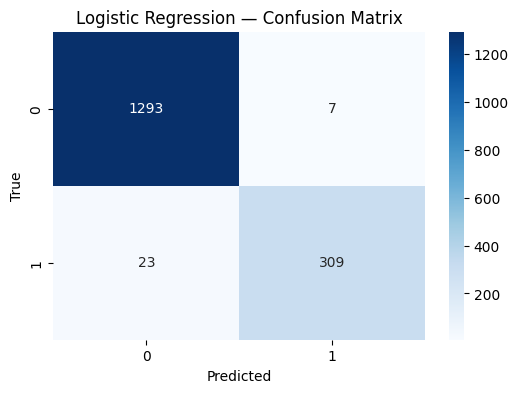

In [104]:
cm = confusion_matrix(y_test, y_pred_lr)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression — Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [105]:
joblib.dump(log_reg, "final_model_lr.pkl")

['final_model_lr.pkl']

8. Conclusion

Logistic Regression achieved the highest accuracy and precision. It's accuracy of 0.981005 proves that it has corectly classified volatility regimes in more than 98% of test cases. Precision score shows that nearly all periods it identified as high-volatility were indeed true high-volatility periods, while the recall value demonstrates that it successfully captured the vast majority of actual high-volatility cases. Random forest performed worse, particularly in recall, and gradient boost came out second. Given such results, one may infer that decision boundry between volatility regimes is mostly linear, which is why logistic regression performed well.